#check on GPU

In [ ]:
!nvidia-smi

Thu Feb 15 10:54:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q \
ultralytics \
supervision \
roboflow

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr" -O market-square.mp4 && rm -rf /tmp/cookies.txt

/content
--2024-02-15 14:04:04--  https://docs.google.com/uc?export=download&confirm=&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr
Resolving docs.google.com (docs.google.com)... 142.250.157.100, 142.250.157.138, 142.250.157.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.157.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr&export=download [following]
--2024-02-15 14:04:05--  https://drive.usercontent.google.com/download?id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.174.132, 2404:6800:4008:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.174.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21302928 (20M) [video/mp4]
Saving to: ‘market-square.mp4’

market-square.mp4   100%[===================>]  20.32M   

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv

In [ ]:
VIDEO_PATH=f"{HOME}/market-square.mp4"

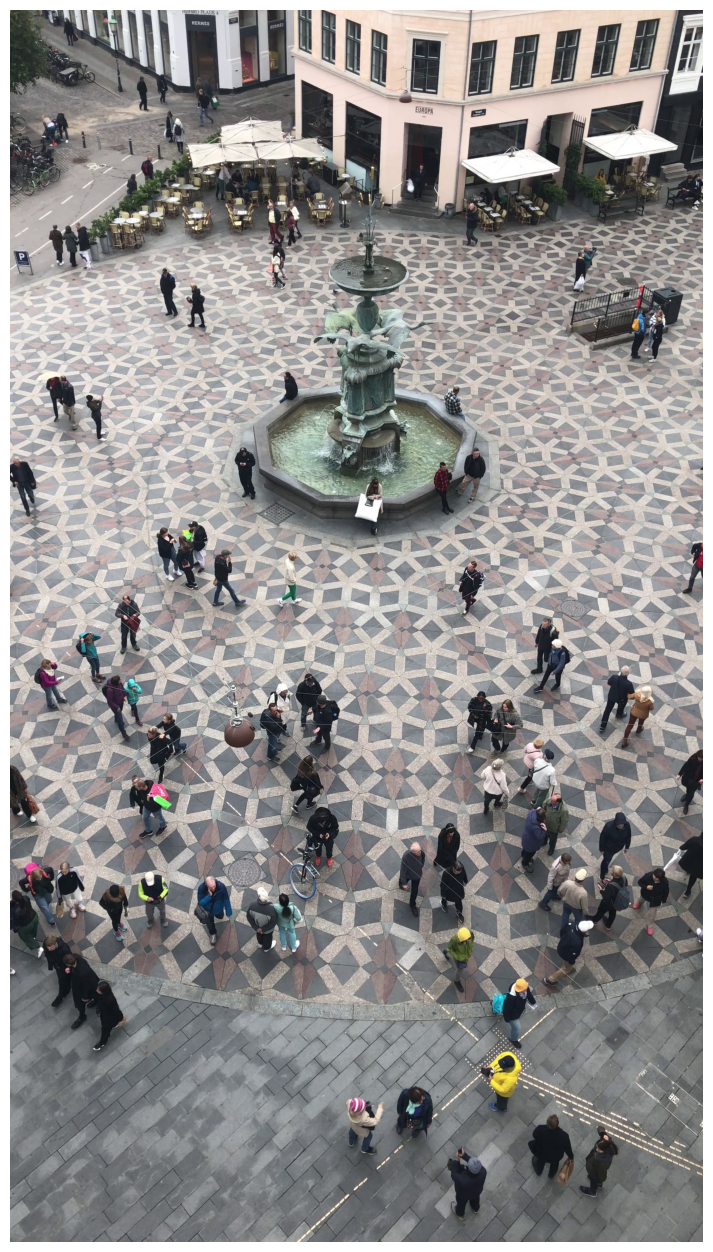

In [ ]:
# extract video frame (get image from the video)
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame,(16,16))

In [ ]:
model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 263MB/s]


102


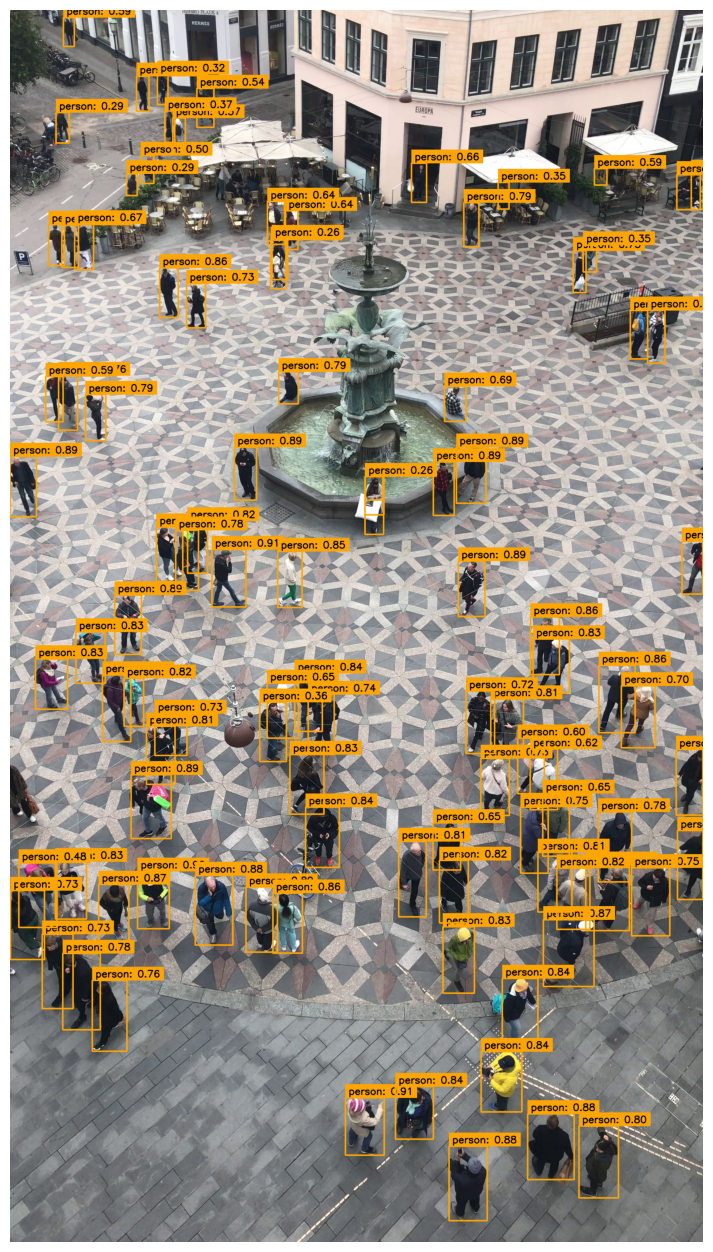

In [ ]:
results = model(frame, imgsz=2304, verbose=False)[0]

detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]
#detections = detections[detections.confidence > 0.3]

print(len(detections))


labels = [
    f"{results.names[class_id]}: {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

box_annotators =sv.BoxAnnotator(thickness=4, text_thickness=2, text_scale=1,color=sv.Color.from_hex("#FFA500"))
frame = box_annotators.annotate(scene=frame, detections=detections, labels=labels)
sv.plot_image(frame,(16,16))

#Draw polygons
Using this tool from [Roboflow](https://roboflow.github.io/polygonzone/)



0: 1248x704 97 persons, 1 bicycle, 1 motorcycle, 1 bench, 1 backpack, 2 umbrellas, 3 chairs, 1 potted plant, 73.8ms
Speed: 9.7ms preprocess, 73.8ms inference, 2.6ms postprocess per image at shape (1, 3, 1248, 704)


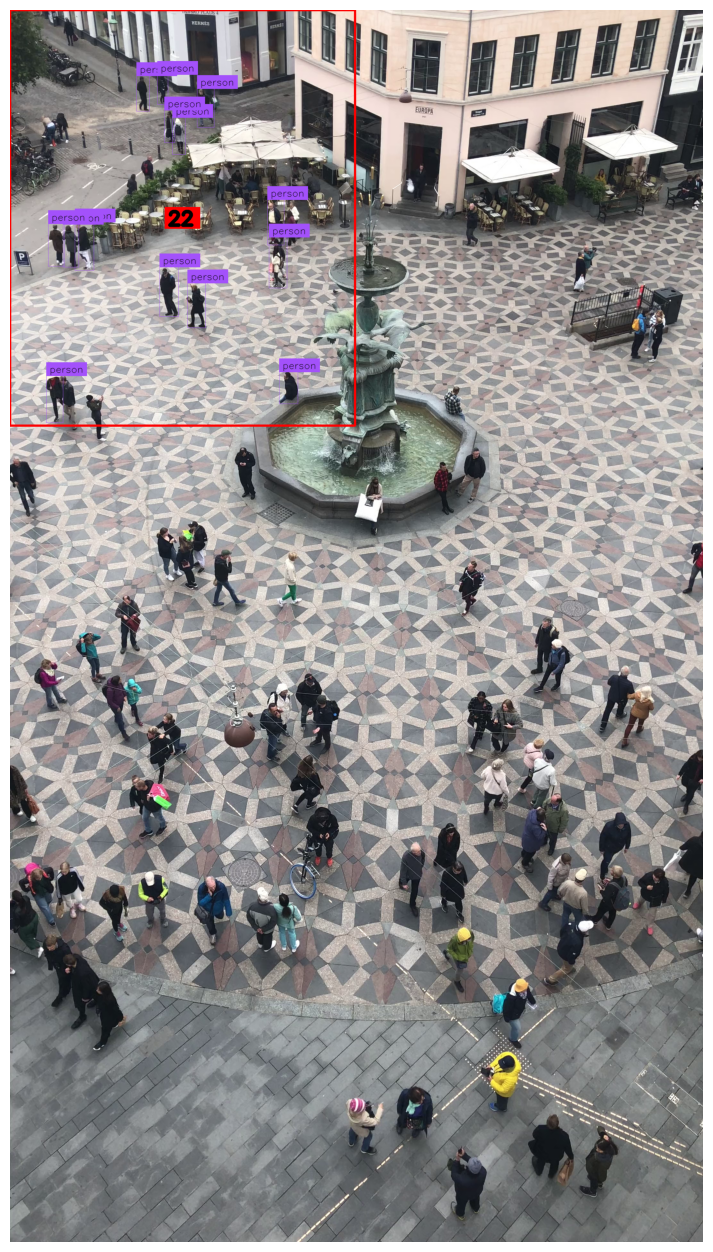

In [ ]:
import numpy as np


polygons = np.array([
    [0, 0],
    [1080 - 5, 0],
    [1080 - 5, 1300 - 5],
    [0, 1300 - 5]
])

colors = sv.ColorPalette.DEFAULT




generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
image = frame
height, width, channels = image.shape


zones =sv.PolygonZone(polygon=polygons, frame_resolution_wh=(width, width))
zone_annotators = sv.PolygonZoneAnnotator( zone=zones, color=sv.Color.RED, thickness=5, text_thickness=10, text_scale=2)

box_annotators =sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=1)


results = model(frame, imgsz=1248)[0]
detections = sv.Detections.from_ultralytics(results)

mask = zones.trigger(detections=detections)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5) & mask]

label_annotator = sv.LabelAnnotator()

labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]



frame = box_annotators.annotate(scene=frame, detections=detections,labels=labels)
frame = zone_annotators.annotate(scene=frame)

sv.plot_image(frame, (16, 16))

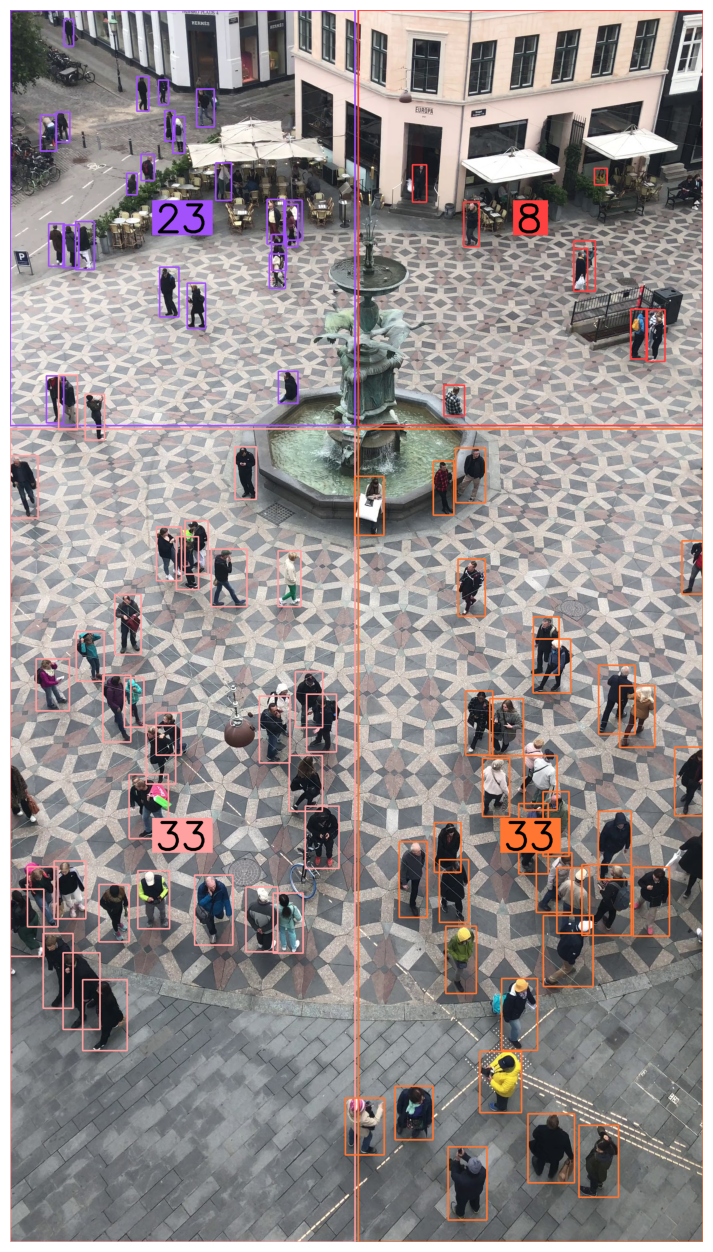

In [ ]:



generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
image = frame
height, width, channels = image.shape

polygons = [
    np.array([
        [0, 0],
        [1080 - 5, 0],
        [1080 - 5, 1300 - 5],
        [0, 1300 - 5]
    ], np.int32),
    np.array([
        [1080 + 5, 0],
        [2160, 0],
        [2160, 1300 - 5],
        [1080 + 5, 1300 - 5]
    ], np.int32),
    np.array([
        [0, 1300 + 5],
        [1080 - 5, 1300 + 5],
        [1080 - 5, 3840],
        [0, 3840]
    ], np.int32),
    np.array([
        [1080 + 5, 1300 + 5],
        [2160, 1300 + 5],
        [2160, 3840],
        [1080 + 5, 3840]
    ], np.int32)
]


zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=(width,width)
    )
    for polygon
    in polygons
]

zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2,
        )
    for index
    in range(len(polygons))
]
label_annotator = sv.LabelAnnotator()



results = model(frame, imgsz=1280, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]

labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]



for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered,skip_label=True)
    #frame= label_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (16, 16))

In [ ]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0]

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

In [ ]:
sv.process_video(source_path=VIDEO_PATH, target_path="result.mp4", callback=process_frame)
